<a href="https://colab.research.google.com/github/twloehfelm/SAR2020/blob/master/03%20-%20Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width="100%">
    <tr>
        <td valign="top"><img src="https://cdn.ymaws.com/www.abdominalradiology.org/graphics/logo.jpg"/></td>
        <td valign="middle" align="right"><h1>SAR 2020<br/>AI Masters Class</h1></td>
    </tr>
    <tr>
      <td align="center" colspan=2><h1>Image Classifier</h1></td>
    </tr>
</table>


**CHEST XRAY CLASSIFIER**

Let's build an image classifier from scratch and see if we can use it to differentiate frontal from lateral chest x-rays.

Frontal and lateral chest x-rays are so similar within-class and so different between classes that differentiating them is a trivial task for a neural network. But, you can use the *exact same code* to train the classifier to differentiate any other classes of images:

*   Pneumothorax vs pneumonia vs normal
*   Stroke vs no stroke
*   HCC vs adenoma
*   Hot dog vs not a hot dog

The more subtle the differences between your classes, the more training data (and time) you'll need.

---

This tutorial is based on Lesson 1 of Practical Deep Learning for Coders v3, a free course offering from [fast.ai](https://course.fast.ai/). I strongly encourage anyone interested to head over to fast.ai to learn more - it's the best resource out there for learning and getting up to speed on image classification as well as more advanced tasks like object detection, image segmentation, and natural language processing.


In [0]:
# Import the required fastai modules
!pip3 install fastai | grep -v 'already satisfied'
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
from fastai.imports import *
from fastai import *

import os

In [0]:
# clean out any old data just to be sure, such as if re-running cells
!rm -rf images
!rm -rf sample_data # Google supplies this but not needed

# Download the CXRs for training
!wget -q --no-check-certificate 'https://www.dropbox.com/s/p32oela6ac63d7e/cxr.zip' -O ./cxr.zip
!mkdir images
!cd images; unzip -q "../cxr.zip" 
!rm -rf ./images/__MACOSX
!ls images

rm: refusing to remove '.' or '..' directory: skipping '.'
cxr


In [0]:
# Save the path to our image directory to a variable named path
path = Path('/content/images/cxr/')
# get_image_files is a convenience function from fastai.vision that looks in `path` and returns a list of all image files it finds
filenames = get_image_files(path)

In [0]:
print(filenames[99])

/content/images/cxr/frontal_0028.jpg


As you can tell from the example filename, the *image class* is encoded in the file name itself. This is a common method of labeling images for machine learning - it ensures that the correct label is always associated with each image rather than in a separate file.

The images are all named in a consistent way:
> `{class}_{serial number}.jpg`

> `frontal_0001.jpg`, `lateral_0056.jpg`, etc.

---
**Protip**

When you can identify a *pattern* that isolates the text you want from a longer string, you can use *regular expressions*, or *RegEx*, to extract the text. The RegEx pattern to extract the class (frontal or lateral) from the full file path ('/content/images/cxr/lateral_0062.jpg') is:


> **`/([^/]+)_\d+.jpg$`**


We'll save this RegEx pattern as a variable called `pattern`.

Learn more about RegEx and pratice at [Pythex.org](https://pythex.org/).


In [0]:
pattern = re.compile(r'/([^/]+)_\d+.jpg$')

In [0]:
# Set required arguments for the fastai ImageDataBunch
validation_percentage=0.5 #We'll do a 50:50 split: train on 50%, validate on 50%
batchsize = 8 # Network weights updated after each batch. Size depends on memory of GPU and image size
imagesize=224 # Images will be resized to 224x224 px
transforms = get_transforms() # Apply random image transformations: horizontal flip, small rotations, etc. Multiplies the number of different images available
np.random.seed(25)

In [0]:
# An ImageDataBunch is a fastai data construct that assembles the images and required settings
# and prepares them for loading in to the neural network. 
data = ImageDataBunch.from_name_re(
    path, 
    filenames, 
    pattern, 
    valid_pct=validation_percentage, 
    ds_tfms = transforms, 
    size=imagesize, 
    bs=batchsize).normalize(imagenet_stats)

In [0]:
# We can look at the ImageDataBunch and see that it contains separate training and validation datasets
data

ImageDataBunch;

Train: LabelList (50 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
lateral,frontal,lateral,lateral,frontal
Path: /content/images/cxr;

Valid: LabelList (50 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
lateral,frontal,lateral,frontal,lateral
Path: /content/images/cxr;

Test: None

In [0]:
# The ImageDataBunch has two classes [frontal, lateral], adn 50 images each in the training and validation datasets
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['frontal', 'lateral'], 2, 50, 50)

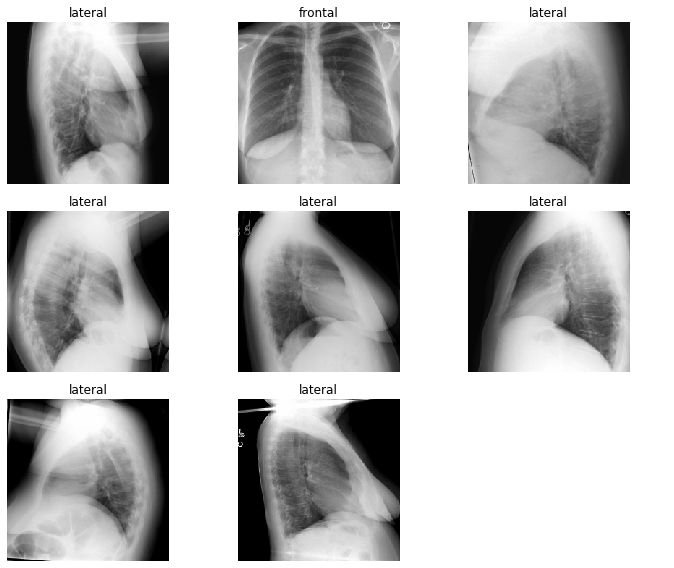

In [0]:
# We can display one batch of 8 images with their associates ground-truth labels
# Note that some of the images have been arbitrarily flipped horizontally
data.show_batch(rows=3, figsize=(10,8))

In [0]:
# Build the neural network learner by passing it our ImageDataBunch
# Note that we are basing it on an existing network, called 
# Resnet34 is pretrained on ImageNet - we'll be modifying the pretrained network to learn about CXRs
learn = cnn_learner(
    data,
    models.resnet34,
    metrics=(error_rate, accuracy)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# Finally we'll start training the network!
# We will have it go through all 50 training images 4 times
# Each time through the entire training set is referred to as an epoch
# Remember that we defined a batch as 8 images, so after every 8 images the network will adjust its settings
# After each epoch it will report back it's current error rate and accuracy
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.187260,0.184911,0.060000,0.940000,00:03
1,0.613465,0.251675,0.100000,0.900000,00:02
2,0.510331,0.218904,0.080000,0.920000,00:02
3,0.405996,0.323042,0.080000,0.920000,00:02


In [0]:
# We can save the trained model and use it later to evaluate new CXRs
learn.save('cxr-frontlat-stage1')
learn.export()

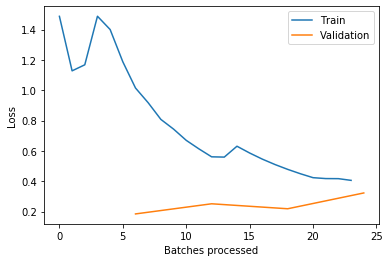

In [0]:
# The goal of a training a neural network is to "minimize the loss function" - the loss function is a
# mathematical formula that quantifies how bad the network is at its assigned task.
# After each batch, the network measures how bad it is and adjusts its parameters in a direction that leads
# to a lower result to the loss function.
learn.recorder.plot_losses()

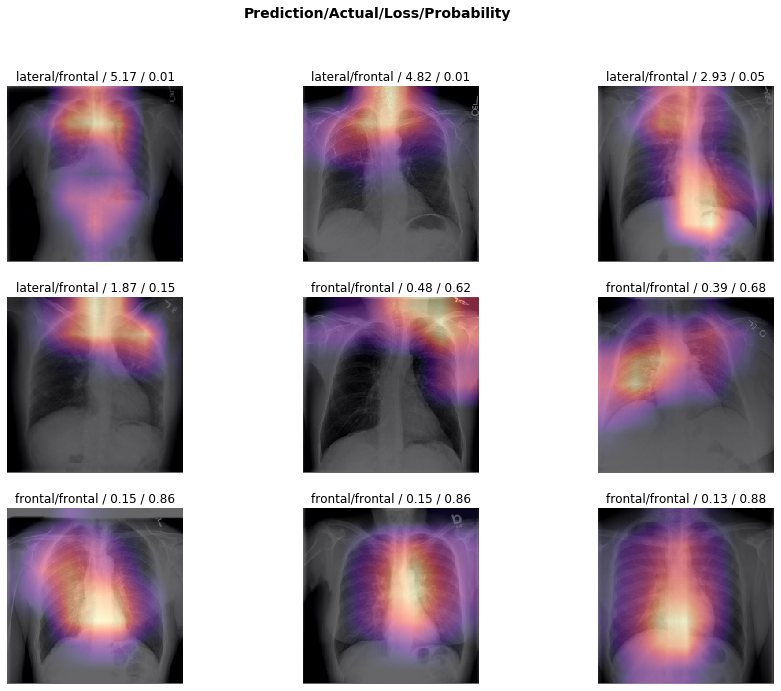

In [0]:
# We can visualize the cases that the network got wrong or was right but less confident in
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

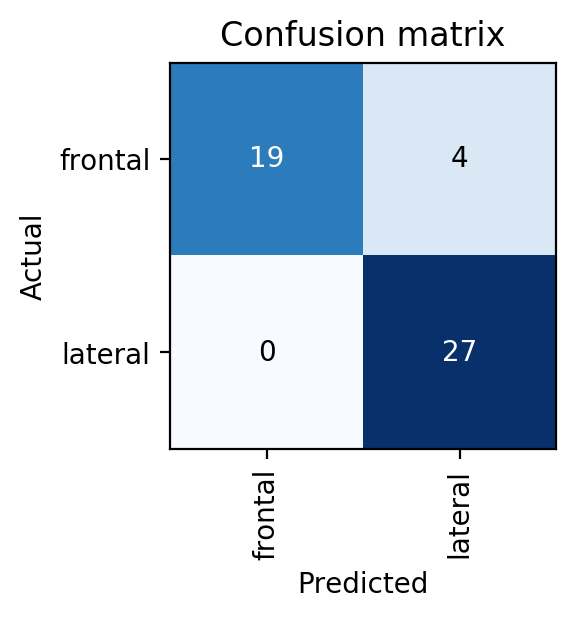

In [0]:
# A confusion matrix plots predicted vs actual
# It is most useful when there are several classes and you can see which classes it is confusing for which others
interp.plot_confusion_matrix(figsize=(3,3), dpi=200)

In [0]:
# Download a brand-new batch of chest x-rays unrelated to those used for training
!wget --no-check-certificate 'https://www.dropbox.com/s/639j1pbq12gs107/palat.zip' -O ./palat.zip

!cd images; unzip -q "../palat.zip" 
!rm -rf ./images/__MACOSX
!ls images

--2020-02-16 18:29:31--  https://www.dropbox.com/s/639j1pbq12gs107/palat.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/639j1pbq12gs107/palat.zip [following]
--2020-02-16 18:29:31--  https://www.dropbox.com/s/raw/639j1pbq12gs107/palat.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3396076e4de155b1c1e1484473.dl.dropboxusercontent.com/cd/0/inline/AyPkSWuQtjvgmQOE8H1bvvTLmKUFiizyDgrkMQME8Uxp5y114W0KDcDEiIHnoFS3o9OhzbQhKo20V--peih5yn4nMhNVxPQMKTgOcjyj6NCiIqiax70fT9KmlnKupYDEBM0/file# [following]
--2020-02-16 18:29:32--  https://uc3396076e4de155b1c1e1484473.dl.dropboxusercontent.com/cd/0/inline/AyPkSWuQtjvgmQOE8H1bvvTLmKUFiizyDgrkMQME8Uxp5y114W0KDcDEiIHnoFS3o9OhzbQhKo20V--peih5yn4nMhNVxPQMKTgOcjyj6NCiIqiax70fT9Kml

In [0]:
# Load the learner (the fully trained network) and apply it to the new images
learn = load_learner('/content/images/cxr/', test=ImageImageList.from_folder('/content/images/palat/test/'))
pred,y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
# Look at a snapshot of predictions - we can see that it is a list where each entry is two numbers -
# the liklihood the network assigns to the given CXR being a PA or lateral.
# The higher number is considered to be the class assignment for that CXR
pred[200:210]

tensor([[5.9256e-04, 9.9941e-01],
        [2.6106e-06, 1.0000e+00],
        [7.1053e-07, 1.0000e+00],
        [1.3224e-06, 1.0000e+00],
        [1.5288e-09, 1.0000e+00],
        [5.0266e-08, 1.0000e+00],
        [1.5222e-07, 1.0000e+00],
        [3.5438e-05, 9.9996e-01],
        [6.3943e-07, 1.0000e+00],
        [8.7125e-01, 1.2875e-01]])

In [0]:
ims = learn.data.test_ds.x
classes = ['frontal','lateral']
# Argmax simply chooses the index of the highest number of the available options
# In this case it choose the higher number for each row in the predictions list
lbls = np.argmax(pred, axis=1)
rows = 40
cols = 10
figsize=(20,70)
fig,axes = plt.subplots(rows,cols,figsize=figsize)
fig.suptitle('predictions', weight='bold',size=14)
for idx,im in enumerate(ims):
  im.show(ax=axes.flat[idx], title=classes[lbls[idx]])